In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

### txt 转换成 csv文件

In [2]:
# C开头的都是分类特征，I开头的是连续特征
train_header = 'Id,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26' 
test_header = 'Id,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26' 
src_path = 'data1/{}.txt'
dst_path = 'data1/{}.csv'

def txt2csv(data_type):
    if data_type == 'train':
        header = train_header
        idx = 10000000
    elif data_type == 'test':
        header = test_header
        idx = 60000000
        
    with open(dst_path.format(data_type), 'w') as f:
        f.write(header + '\r\n')
        for line in open(src_path.format(data_type), 'r'):
            line = str(idx) + ',' + line.replace('\t', ',')
            f.write(line.replace('\n', '\r\n'))
            idx += 1
def convert_to_csv():
    print('train data begin..')
    txt2csv('train')
    if os.path.exists(dst_path.format('train')):
        print('train data has been converted!')
    print('test data begin..')
    txt2csv('test')
    if os.path.exists(dst_path.format('test')):
        print('test data has been converted!')

if not os.path.exists(dst_path.format('train')) or not os.path.exists(dst_path.format('test')):
    convert_to_csv()

### 加载train test数据

In [3]:
df_train = pd.read_csv(dst_path.format('train'))
df_test = pd.read_csv(dst_path.format('test'))

In [4]:
print('train data shape->', df_train.shape)
print('test data shape->', df_test.shape)

train data shape-> (45840617, 41)
test data shape-> (6042135, 40)


In [5]:
df_train.head()

,Id,Label,I1,I2,I3,I4,I5,I6,I7,I8,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,10000000,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,10000001,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,10000002,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,10000003,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,10000004,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [6]:
df_test.head()

,Id,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,60000000,NaN,29,50.0,5.0,7260.0,437.0,1.0,4.0,14.0,...,3486227d,1616f155,21ddcdc9,5840adea,2c277e62,NaN,423fab69,54c91918,9b3e8820,e75c9ae9
1,60000001,27.0,17,45.0,28.0,2.0,28.0,27.0,29.0,28.0,...,e5ba7672,b4abdd09,21ddcdc9,5840adea,36a7ab86,NaN,32c7478e,85e4d73f,010f6491,ee63dd9b
2,60000002,1.0,1,19.0,7.0,1.0,3.0,1.0,7.0,7.0,...,d4bb7bd8,bd17c3da,1d04f4a4,a458ea53,82bdc0bb,NaN,32c7478e,5bdcd9c4,010f6491,cca57dcc
3,60000003,4.0,1,NaN,6.0,1051.0,134.0,4.0,35.0,72.0,...,07c540c4,bdc06043,NaN,NaN,6dfd157c,ad3062eb,423fab69,ef089725,NaN,NaN
4,60000004,7.0,1,25.0,10.0,139.0,74.0,48.0,13.0,44.0,...,27c07bd6,395856b0,21ddcdc9,a458ea53,9c3eb598,ad3062eb,3a171ecb,c0b8dfd6,001f3601,7a2fb9af


In [7]:
print('nums of training data Label=0 ->', df_train[df_train.Label==0].shape[0])
print('nums of training data Label=1 ->', df_train[df_train.Label==1].shape[0])

nums of training data Label=0 -> 34095179
nums of training data Label=1 -> 11745438


In [4]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 10798.10 Mb (24.7% reduction)
Mem. usage decreased to 1405.98 Mb (23.7% reduction)


In [5]:
continuous_features = [value for value in df_train.columns.values if 'I' in value and value!='Id']
category_features = [value for value in df_train.columns.values if 'C' in value]

### 数据处理
step1:under-sample<br>
step2:split data<br>
step3:feature-transform(contains continuous features scaled& category features labelhot)

In [6]:
def normal_subsample_data(df, freq, random_state):
    """
    base: 数据量过大，进行随机采样处理
    """
    df = df.sample(frac=freq, replace=True, random_state=1)
    return df

def sample_data(df_train):
    """
    step1: 数据下采样
    """
    # train数据量太大，先减半
    df_train = normal_subsample_data(df_train, 0.5, 2)
    # training set的label=1和label=0数量不同
    label_0_size = df_train[df_train.Label==0].shape[0]
    label_1_size = df_train[df_train.Label==1].shape[0]
    if label_0_size > label_1_size:
        freq = round(label_1_size/label_0_size,2)
        print('Under sample frac is:', freq)
        df_train_0 = normal_subsample_data(df_train[df_train.Label==0], freq, 1)
        df_train_1 = df_train[df_train.Label==1]
        print('label=0 shape:', df_train_0.shape)
        print('label=1 shape:', df_train_1.shape)
        df_train = pd.concat([df_train_0, df_train_1], ignore_index=True)
    else:
        freq = round(label_0_size/label_1_size,2)
        print('Under sample frac is:', freq)
        df_train_1 = normal_subsample_data(df_train[df_train.Label==1], freq, 1)
        df_train_0 = df_train[df_train.Label==0]
        print('label=0 shape:', df_train_0.shape)
        print('label=1 shape:', df_train_1.shape)
        df_train = pd.concat([df_train_0, df_train_1], ignore_index=True)
    
    # 进行一个shuffle
    df_train = df_train.sample(frac=1).reset_index(drop=True)

    return df_train

def split_data(df_train):
    """
    step3: 分训练集/验证集
    """
    X = df_train.drop('Label', axis=1)
    y = df_train['Label']
    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    for train_index, test_index in skf.split(X,y):
        original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
        original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    # 转换成array
    original_Xtrain_values = original_Xtrain.values
    original_Xtest_values = original_Xtest.values
    original_ytrain_values = original_ytrain.values
    original_ytest_values = original_ytest.values

    train_unique_label, train_counts_label = np.unique(original_ytrain_values, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest_values, return_counts=True)
    print(train_unique_label, train_counts_label)
    print('Label Distributions: \n')
    print(train_counts_label/ len(original_ytrain_values))
    print(test_counts_label/ len(original_ytest_values))
    return original_Xtrain, original_ytrain, original_Xtest, original_ytest

def feature_transform(df_train, df_test, category_features, continuous_features):
    """
    step2: 划分好的数据集进行feature transform
    """
    # 将类别feature中的NaN作为一个类别
    origin_train = df_train.copy()
    origin_test = df_test.copy()
    origin_train[category_features] = origin_train[category_features].fillna('NaN')
    origin_test[category_features] = origin_test[category_features].fillna('NaN')
    origin_train[continuous_features] = origin_train[continuous_features].fillna(0)
    origin_test[continuous_features] = origin_test[continuous_features].fillna(0)

    category_concat = pd.concat([origin_train[category_features], origin_test[category_features]], ignore_index=True)
    for feature in category_features:
        lb = preprocessing.LabelEncoder().fit(category_concat[feature])
        origin_train[feature] = lb.transform(origin_train[feature])
        origin_test[feature] = lb.transform(origin_test[feature])
        
    scaler = preprocessing.StandardScaler().fit(origin_train[continuous_features])
    origin_train[continuous_features] = scaler.transform(origin_train[continuous_features])
    origin_test[continuous_features] = scaler.transform(origin_test[continuous_features])
    return origin_train, origin_test
    

In [7]:
df_train_sample = sample_data(df_train)

Under sample frac is: 0.34
label=0 shape: (5795809, 41)
label=1 shape: (5873812, 41)


In [8]:
original_Xtrain_trans, original_Xtest_trans = feature_transform(df_train_sample, df_test, category_features, continuous_features)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float16, int32, float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:82: DataConversionWarning: Data with input dtype float16, int32, float32 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:83: DataConversionWarning: Data with input dtype float16, int16, float32 were all converted to float64 by StandardScaler.


In [116]:
# resumetable(original_Xtrain)

Dataset Shape: (11517649, 40)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Id,int32,0,9054286,48701735,41031570,18363270,23.00
1,I1,float16,4938501,459,4,3,2,3.22
2,I2,int32,0,7011,26,1,3,6.08
3,I3,float32,2571283,7016,4,nan,7,5.17
4,I4,float16,2550749,285,5,47,8,4.30
5,I5,float32,259493,236323,24,5,25,12.94
6,I6,float32,2312258,7054,2,35,7,7.51
7,I7,float16,453167,2622,15,67,2,4.93
8,I8,float16,4951,699,5,41,9,5.02
9,I9,float16,453167,3746,25,96,8,7.83


In [10]:
# 保存数据
if not os.path.exist('train_data.pkl') and not os.path.exist('test_data.pkl'):
    original_Xtrain_trans.to_pickle('train_data.pkl')
    original_Xtest_trans.to_pickle('test_data.pkl')


### heatmap-相关性
c9和I5负相关

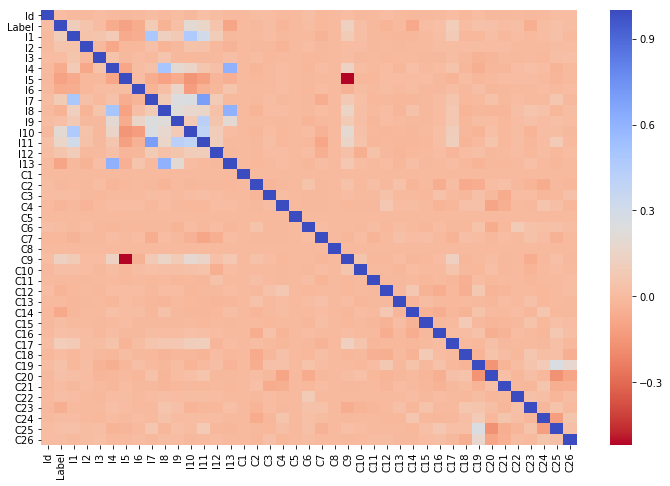

In [122]:
plt.figure(figsize=(12,8))
original_Xtrain_corr = original_Xtrain_trans.corr()
sns.heatmap(original_Xtrain_corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.show()

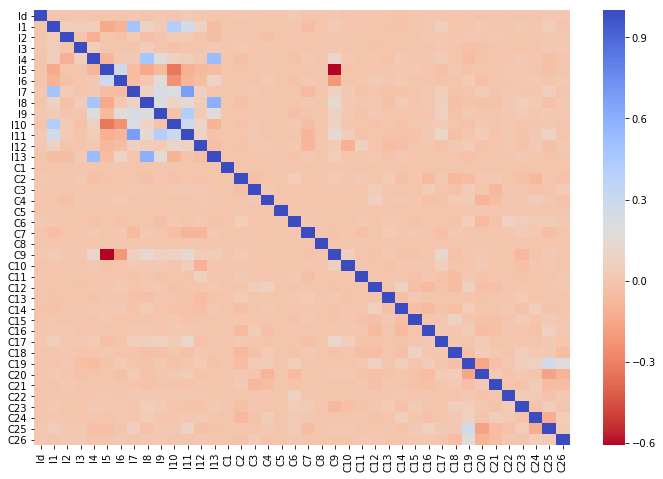

In [143]:
plt.figure(figsize=(12,8))
original_Xtest_corr = original_Xtest_trans.corr()
sns.heatmap(original_Xtest_corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.show()

In [13]:
# t-SNE
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(original_Xtrain_trans[category_features].values[:10000])
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# # PCA Implementation
# t0 = time.time()
# X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(original_Xtrain_trans.values[:100])
# t1 = time.time()
# print("PCA took {:.2} s".format(t1 - t0))

# # TruncatedSVD
# t0 = time.time()
# X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(original_Xtrain_trans.values[:100])
# t1 = time.time()
# print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 7.7e+01 s


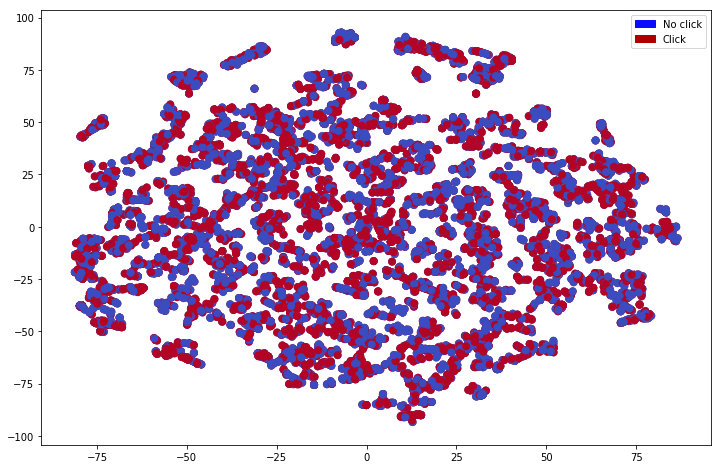

In [14]:
blue_patch = mpatches.Patch(color='#0A0AFF', label='No click')
red_patch = mpatches.Patch(color='#AF0000', label='Click')
plt.figure(figsize=(12,8))
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(original_Xtrain_trans.Label[:10000]== 0), cmap='coolwarm', label='No click', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(original_Xtrain_trans.Label[:10000]== 1), cmap='coolwarm', label='Click', linewidths=2)
plt.legend(handles=[blue_patch, red_patch])

### LR预测

In [157]:
def lr_predict(original_Xtrain_trans):
    # 5折交叉验证
    X = original_Xtrain_trans.drop('Label', axis=1)
    y = original_Xtrain_trans['Label']
    ss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    iter_num = 0
    kl_res = []
    mse_res = []
    for train_index, val_index in ss.split(X, y):
        print("Iter:{} Begin!".format(iter_num))
        iter_num += 1
        X_train_values = X.loc[train_index].values
        y_train_values = y.loc[train_index].values
        X_val_values = X.loc[val_index].values
        y_val_values = y.loc[val_index].values
        print("X train shape is:", X_train_values.shape)
        print("X val shape is:", X_val_values.shape)
        lr_classifier = LogisticRegression(solver='lbfgs').fit(X_train_values, y_train_values)
        y_predict = lr_classifier.predict_proba(X_val_values)
        print('y_predict shape:', y_predict[:10])
        print('y val shape:', y_val_values[:10])
        mse = mean_squared_error(y_predict[:,1], y_val_values)
        kl = mutual_info_score(y_predict[:,1], y_val_values)
        print('MSE: ', mse)
        print('KL: ', kl)
        kl_res.append(kl)
        mse_res.append(mse)
        print('####################')
    return kl_res, mse_res

In [158]:
kl_res, mse_res = lr_predict(original_Xtrain_trans)

Iter:0 Begin!
X train shape is: (9335696, 40)
X val shape is: (2333925, 40)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


y_predict shape: [[0.47250665 0.52749335]
 [0.50429917 0.49570083]
 [0.52225903 0.47774097]
 [0.48968581 0.51031419]
 [0.51731951 0.48268049]
 [0.46604852 0.53395148]
 [0.53084545 0.46915455]
 [0.45343652 0.54656348]
 [0.4861013  0.5138987 ]
 [0.4618253  0.5381747 ]]
y val shape: [0 0 1 1 1 1 1 0 0 0]
MSE:  0.24939811834489597
KL:  0.6931248394718925
####################
Iter:1 Begin!
X train shape is: (9335696, 40)
X val shape is: (2333925, 40)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


y_predict shape: [[0.45356844 0.54643156]
 [0.47187833 0.52812167]
 [0.51257464 0.48742536]
 [0.47469625 0.52530375]
 [0.4762791  0.5237209 ]
 [0.4723507  0.5276493 ]
 [0.46750814 0.53249186]
 [0.48048876 0.51951124]
 [0.51831511 0.48168489]
 [0.48363839 0.51636161]]
y val shape: [1 1 1 1 1 1 1 1 1 1]
MSE:  0.2494446412418757
KL:  0.6931248394718922
####################
Iter:2 Begin!
X train shape is: (9335697, 40)
X val shape is: (2333924, 40)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


y_predict shape: [[0.477883   0.522117  ]
 [0.52955239 0.47044761]
 [0.49858683 0.50141317]
 [0.49240802 0.50759198]
 [0.4671641  0.5328359 ]
 [0.49929392 0.50070608]
 [0.4932493  0.5067507 ]
 [0.49316574 0.50683426]
 [0.49802451 0.50197549]
 [0.45140315 0.54859685]]
y val shape: [1 1 1 1 1 1 1 1 1 1]
MSE:  0.24943138848412377
KL:  0.6931248423167374
####################
Iter:3 Begin!
X train shape is: (9335697, 40)
X val shape is: (2333924, 40)
y_predict shape: [[0.51857164 0.48142836]
 [0.48828025 0.51171975]
 [0.52612492 0.47387508]
 [0.46571803 0.53428197]
 [0.50765987 0.49234013]
 [0.49801079 0.50198921]
 [0.51921542 0.48078458]
 [0.48009518 0.51990482]
 [0.50112649 0.49887351]
 [0.48393307 0.51606693]]
y val shape: [1 1 1 1 1 1 1 1 1 1]
MSE:  0.24945007275642536
KL:  0.6931248423167372
####################
Iter:4 Begin!
X train shape is: (9335698, 40)
X val shape is: (2333923, 40)
y_predict shape: [[0.5247245  0.4752755 ]
 [0.4527625  0.5472375 ]
 [0.51830506 0.48169494]
 [0.4914

In [160]:
print('MSE-mean:', np.mean(mse_res))
print('KL-mean:', np.mean(kl_res))

MSE-mean: 0.24942954039389834
KL-mean: 0.6931248406021722


### gbdt预测

In [2]:
original_Xtrain_trans = pd.read_pickle('train_data.pkl')

In [9]:
def gbdt_gs(original_Xtrain_trans):
    X = original_Xtrain_trans.drop('Label', axis=1)
    y = original_Xtrain_trans['Label']
    gbdt_params = {'learning_rate':[0.001, 0.01, 0.02, 0.1],
                   'num_leaves':[5,10,31],
                   'max_depth':[5,10,30],
                   'n_estimators':[100, 300, 500, 600, 1000],
                   'subsample': [1, 0.75, 0.5]
                   }
    classifer = lgb.LGBMClassifier(objective='binary',metric='auc',
                                   boosting_type='gbdt',silent=False, n_jobs=5,
                                   device='gpu',
                                   gpu_platform_id=0,
                                   gpu_device_id=1)
    ss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    gs = RandomizedSearchCV(estimator=classifer, param_distributions=gbdt_params, cv=ss, n_jobs=4, verbose=10)
    gs.fit(X,y)
    return gs

In [10]:
gs = gbdt_gs(original_Xtrain_trans)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 19.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 25.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 40.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 52.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 60.5min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 71.2min finished


In [14]:
gs.best_params_

{'subsample': 0.5,
 'num_leaves': 31,
 'n_estimators': 1000,
 'max_depth': 30,
 'learning_rate': 0.1}

In [15]:
def gbdt_predict(original_Xtrain_trans):
    X = original_Xtrain_trans.drop('Label', axis=1)
    y = original_Xtrain_trans['Label']
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size = 0.2, random_state = 2018)
    
    classifer = lgb.LGBMClassifier(
                            objective='binary',metric='auc',
                            boosting_type='gbdt',silent=False, n_jobs=5,
                            device='gpu',
                            gpu_platform_id=0,
                            gpu_device_id=1,
                            subsample=0.5,
                            num_leaves=31,
                            n_estimators=1000,
                            max_depth=30,
                            learning_rate=0.1
    ).fit(X_train, y_train)
    y_predict = classifer.predict_proba(X_val)
    mse = mean_squared_error(y_predict[:,1], y_val)
    print(mse)

In [16]:
gbdt_predict(original_Xtrain_trans)

0.1896609330555318


### GBDT+LR预测

In [18]:
def gbdt_lr_predict(original_Xtrain_trans):
    X = original_Xtrain_trans.drop('Label', axis=1)
    y = original_Xtrain_trans['Label']
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size = 0.2, random_state = 2019)
    gbm = lgb.LGBMRegressor(objective='binary',metric='auc',
                            boosting_type='gbdt',silent=False, n_jobs=5,
                            device='gpu',
                            gpu_platform_id=0,
                            gpu_device_id=1,
                            subsample=0.5,
                            num_leaves=31,
                            n_estimators=1000,
                            max_depth=30,
                            learning_rate=0.1).fit(X_train, y_train)
    model = gbm.booster_
    

In [19]:
X = original_Xtrain_trans.drop('Label', axis=1)

In [20]:
y = original_Xtrain_trans['Label']

In [21]:
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size = 0.2, random_state = 2019)

In [23]:
gbm = lgb.LGBMRegressor(objective='binary',metric='auc',
                            boosting_type='gbdt',silent=False, n_jobs=5,
                            device='gpu',
                            gpu_platform_id=0,
                            gpu_device_id=1,
                            subsample=0.5,
                            num_leaves=31,
                            n_estimators=1000,
                            max_depth=30,
                            learning_rate=0.1).fit(X_train, y_train)

In [34]:
gbm1 = lgb.LGBMClassifier(objective='binary',metric='auc',
                            boosting_type='gbdt',silent=False, n_jobs=5,
                            device='gpu',
                            gpu_platform_id=0,
                            gpu_device_id=1,
                            subsample=0.5,
                            num_leaves=31,
                            n_estimators=500,
                            max_depth=30,
                            learning_rate=0.1).fit(X_train, y_train)

In [42]:
gbm2 = lgb.LGBMRegressor(objective='binary',metric='auc',
                            boosting_type='gbdt',silent=False, n_jobs=5,
                            device='gpu'≈,
                            gpu_platform_id=0,
                            gpu_device_id=1,
                            subsample=0.5,
                            num_leaves=31,
                            n_estimators=500,
                            max_depth=30,
                            learning_rate=0.1
                            )
gbm2.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_val, y_val)],
            eval_names = ['train', 'val'],
            eval_metric = 'binary_logloss',
            early_stopping_rounds = 100,
            )

[1]	train's binary_logloss: 0.681559	train's auc: 0.700292	val's binary_logloss: 0.681557	val's auc: 0.70039
Training until validation scores don't improve for 100 rounds
[2]	train's binary_logloss: 0.67197	train's auc: 0.706877	val's binary_logloss: 0.67197	val's auc: 0.70694
[3]	train's binary_logloss: 0.663913	train's auc: 0.709568	val's binary_logloss: 0.6639	val's auc: 0.709691
[4]	train's binary_logloss: 0.657107	train's auc: 0.7112	val's binary_logloss: 0.657099	val's auc: 0.711272
[5]	train's binary_logloss: 0.651432	train's auc: 0.712359	val's binary_logloss: 0.651433	val's auc: 0.712381
[6]	train's binary_logloss: 0.646597	train's auc: 0.71359	val's binary_logloss: 0.646588	val's auc: 0.713634
[7]	train's binary_logloss: 0.642383	train's auc: 0.714417	val's binary_logloss: 0.642374	val's auc: 0.714457
[8]	train's binary_logloss: 0.638797	train's auc: 0.715123	val's binary_logloss: 0.638789	val's auc: 0.715149
[9]	train's binary_logloss: 0.635617	train's auc: 0.716245	val's bi

[75]	train's binary_logloss: 0.589333	train's auc: 0.753485	val's binary_logloss: 0.589307	val's auc: 0.753458
[76]	train's binary_logloss: 0.589044	train's auc: 0.753793	val's binary_logloss: 0.589017	val's auc: 0.75377
[77]	train's binary_logloss: 0.588893	train's auc: 0.753931	val's binary_logloss: 0.588873	val's auc: 0.753901
[78]	train's binary_logloss: 0.588628	train's auc: 0.754194	val's binary_logloss: 0.588608	val's auc: 0.754164
[79]	train's binary_logloss: 0.588421	train's auc: 0.754398	val's binary_logloss: 0.588408	val's auc: 0.754359
[80]	train's binary_logloss: 0.588236	train's auc: 0.754581	val's binary_logloss: 0.588222	val's auc: 0.754544
[81]	train's binary_logloss: 0.588097	train's auc: 0.754696	val's binary_logloss: 0.58808	val's auc: 0.754665
[82]	train's binary_logloss: 0.587883	train's auc: 0.754924	val's binary_logloss: 0.587867	val's auc: 0.75489
[83]	train's binary_logloss: 0.587702	train's auc: 0.755138	val's binary_logloss: 0.587681	val's auc: 0.755111
[84]

[149]	train's binary_logloss: 0.579417	train's auc: 0.763793	val's binary_logloss: 0.579488	val's auc: 0.763664
[150]	train's binary_logloss: 0.579353	train's auc: 0.763852	val's binary_logloss: 0.579427	val's auc: 0.76372
[151]	train's binary_logloss: 0.579262	train's auc: 0.763948	val's binary_logloss: 0.579339	val's auc: 0.763812
[152]	train's binary_logloss: 0.579207	train's auc: 0.764	val's binary_logloss: 0.579288	val's auc: 0.76386
[153]	train's binary_logloss: 0.579149	train's auc: 0.764067	val's binary_logloss: 0.579231	val's auc: 0.763926
[154]	train's binary_logloss: 0.579067	train's auc: 0.764158	val's binary_logloss: 0.579154	val's auc: 0.76401
[155]	train's binary_logloss: 0.578989	train's auc: 0.764234	val's binary_logloss: 0.57908	val's auc: 0.764082
[156]	train's binary_logloss: 0.578933	train's auc: 0.764294	val's binary_logloss: 0.579025	val's auc: 0.764142
[157]	train's binary_logloss: 0.578863	train's auc: 0.764371	val's binary_logloss: 0.578958	val's auc: 0.764215

[223]	train's binary_logloss: 0.574774	train's auc: 0.768708	val's binary_logloss: 0.575106	val's auc: 0.768449
[224]	train's binary_logloss: 0.574738	train's auc: 0.768744	val's binary_logloss: 0.57507	val's auc: 0.768485
[225]	train's binary_logloss: 0.574691	train's auc: 0.768796	val's binary_logloss: 0.575025	val's auc: 0.768536
[226]	train's binary_logloss: 0.574641	train's auc: 0.76885	val's binary_logloss: 0.574974	val's auc: 0.76859
[227]	train's binary_logloss: 0.574577	train's auc: 0.768915	val's binary_logloss: 0.574912	val's auc: 0.768655
[228]	train's binary_logloss: 0.57452	train's auc: 0.768974	val's binary_logloss: 0.574857	val's auc: 0.768711
[229]	train's binary_logloss: 0.57449	train's auc: 0.769002	val's binary_logloss: 0.574829	val's auc: 0.768737
[230]	train's binary_logloss: 0.574447	train's auc: 0.76906	val's binary_logloss: 0.57482	val's auc: 0.76879
[231]	train's binary_logloss: 0.574381	train's auc: 0.769127	val's binary_logloss: 0.574755	val's auc: 0.768855


[297]	train's binary_logloss: 0.571502	train's auc: 0.772214	val's binary_logloss: 0.57204	val's auc: 0.77182
[298]	train's binary_logloss: 0.571444	train's auc: 0.772278	val's binary_logloss: 0.571984	val's auc: 0.771881
[299]	train's binary_logloss: 0.571422	train's auc: 0.772294	val's binary_logloss: 0.571963	val's auc: 0.771896
[300]	train's binary_logloss: 0.571387	train's auc: 0.772326	val's binary_logloss: 0.571921	val's auc: 0.771924
[301]	train's binary_logloss: 0.571328	train's auc: 0.77239	val's binary_logloss: 0.571862	val's auc: 0.771987
[302]	train's binary_logloss: 0.571296	train's auc: 0.772424	val's binary_logloss: 0.57183	val's auc: 0.772021
[303]	train's binary_logloss: 0.571259	train's auc: 0.77246	val's binary_logloss: 0.571793	val's auc: 0.772056
[304]	train's binary_logloss: 0.571199	train's auc: 0.772521	val's binary_logloss: 0.571735	val's auc: 0.772116
[305]	train's binary_logloss: 0.571142	train's auc: 0.772583	val's binary_logloss: 0.571679	val's auc: 0.7721

[371]	train's binary_logloss: 0.568983	train's auc: 0.774868	val's binary_logloss: 0.569652	val's auc: 0.774359
[372]	train's binary_logloss: 0.568934	train's auc: 0.774918	val's binary_logloss: 0.569604	val's auc: 0.774408
[373]	train's binary_logloss: 0.568897	train's auc: 0.774957	val's binary_logloss: 0.56957	val's auc: 0.774445
[374]	train's binary_logloss: 0.568846	train's auc: 0.775012	val's binary_logloss: 0.569519	val's auc: 0.774499
[375]	train's binary_logloss: 0.568816	train's auc: 0.775035	val's binary_logloss: 0.569493	val's auc: 0.774518
[376]	train's binary_logloss: 0.568804	train's auc: 0.775047	val's binary_logloss: 0.569483	val's auc: 0.774528
[377]	train's binary_logloss: 0.568782	train's auc: 0.775074	val's binary_logloss: 0.569459	val's auc: 0.774555
[378]	train's binary_logloss: 0.568724	train's auc: 0.775133	val's binary_logloss: 0.569403	val's auc: 0.774614
[379]	train's binary_logloss: 0.568704	train's auc: 0.775155	val's binary_logloss: 0.569384	val's auc: 0.

[445]	train's binary_logloss: 0.567037	train's auc: 0.777005	val's binary_logloss: 0.567793	val's auc: 0.776357
[446]	train's binary_logloss: 0.567015	train's auc: 0.777028	val's binary_logloss: 0.567772	val's auc: 0.77638
[447]	train's binary_logloss: 0.567001	train's auc: 0.777041	val's binary_logloss: 0.567761	val's auc: 0.77639
[448]	train's binary_logloss: 0.566987	train's auc: 0.777058	val's binary_logloss: 0.567749	val's auc: 0.776404
[449]	train's binary_logloss: 0.566941	train's auc: 0.777102	val's binary_logloss: 0.567703	val's auc: 0.776449
[450]	train's binary_logloss: 0.566906	train's auc: 0.777134	val's binary_logloss: 0.567669	val's auc: 0.77648
[451]	train's binary_logloss: 0.566884	train's auc: 0.777156	val's binary_logloss: 0.567647	val's auc: 0.776502
[452]	train's binary_logloss: 0.566867	train's auc: 0.777174	val's binary_logloss: 0.567631	val's auc: 0.776519
[453]	train's binary_logloss: 0.566848	train's auc: 0.777195	val's binary_logloss: 0.567615	val's auc: 0.77

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       device='gpu', gpu_device_id=1, gpu_platform_id=0,
       importance_type='split', learning_rate=0.1, max_depth=30,
       metric='auc', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=500, n_jobs=5, num_leaves=31,
       objective='binary', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=False, subsample=0.5,
       subsample_for_bin=200000, subsample_freq=0)

In [44]:
model = gbm2.booster_
gbdt_feats_train = model.predict(X_train, pred_leaf = True)

In [29]:
gbdt_feats_test = model.predict(, pred_leaf = True)

(9335696, 1000)

In [30]:
X_train.shape

(9335696, 40)

In [35]:
model1 = gbm1.booster_
gbdt_feats_train1 = model1.predict(X_train, pred_leaf = True)

In [36]:
gbdt_feats_train1.shape

(9335696, 500)